In [1]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Preprossessing

In [2]:
def add_previous_transaction_data(df, artists):
    data_proc_prev = df.copy()
    colList = ["sale_year","sale_month","log_nom_price","paint_date","age","area"]
    prev_colList = []
    for col in colList:
        prev_string = "".join(("P_",col))
        data_proc_prev[prev_string] = 0
        
    for name in mergelist.name:
        for col in colList:
            prev_string = "".join(("P_",col))
            data_proc_prev.loc[data_proc_prev[name]==1,prev_string] = data_proc.loc[data_proc[name]==1,col].shift(1)
    #adds a column to indicate if there are NA values
    data_proc_prev["no_prev_sale"] = 0
    data_proc_prev["no_prev_sale"] = data_proc_prev['P_sale_year'].isna().apply(lambda x: 1 if x==True else 0)
    data_proc_prev = data_proc_prev.fillna(0)
      
    return data_proc_prev

In [7]:
data = pd.read_csv("pricedeathcor.csv",encoding= 'unicode_escape')
artists = data.artist.unique()[1:]
mergelist = np.empty([len(artists),3],dtype=object)
for i,artist in enumerate(artists):
    name, info = artist.split(" (") #splits of name from year data
    _,death = info.split("d. ") # splits off death data from birth
    death = death[:-1] #removes trailing parenthesis
    mergelist[i] = [artist, name, death]
mergelist = pd.DataFrame(mergelist,columns=["artist","name","death"])
data = data.merge(mergelist)
data.death = pd.to_numeric(data.death)

#drops data except for price estimates

top_houses = ["Christie's New York","Christie's London","Sotheby's New York","Sotheby's London",]
data = data[data.house.isin(top_houses)]
data = data.drop(["auction_name_lot","hammer","pdate","date","lot_no","curr","cpi","saleyear","omeana","larea","saleprice","american"],1)
medianPrice = np.asarray((data.low_est.values + data.high_est.values)/2)
salePrice = np.asarray(data.nomprice.values)
data = data.drop(["low_est","high_est"],axis=1)

#subtracts year of death of family member from year of death to make their magnitude more significant
relations = ["father",	"mother",	"wife1",	"wife2",	"child1",	"child2",	"friend1", "friend2",	"friend3",	"brother",	"sister"]
for rel in relations:
    data[rel] = data[rel] - data.birth1

#removes relationship columns
#data = data.drop(relations,1)

#dropping rows without sale price data
data = data[data.nomprice.isna()==False]
#dropping rows without titles for painting (this is only 4 rows so not impactful)
data = data[data.title.isna()==False]
#replacing NaN's from death columns to 0's for boolean encoding
data = data.fillna(0) #not specifying which columns since only cols remaining without Nan's are the death cols
#drops the bad row
data = data.drop(index=12989,axis=0)

#ADDED COLUMNS
#adds log nom price column
data["log_nom_price"] = np.log(data.nomprice)

#changes saledate string into pandas datetime and extracts the month and day
data["datestring"] = pd.to_datetime(data.datestring)
data["sale_year"] = pd.DatetimeIndex(data['datestring']).year
data["sale_month"] = pd.DatetimeIndex(data['datestring']).month
#data["sale_day"] = pd.DatetimeIndex(data['datestring']).day
#i commend out weekday, even though it does add a lot of info to model
#since the seller wouldnt know this ahead of time
#data["weekday"] = pd.DatetimeIndex(data['datestring']).dayofweek

#creates onehot vectors
name_onehot = pd.get_dummies(data.name)
house_onehot = pd.get_dummies(data.house)
data_proc = data.copy()

#drops string data from df
data_proc = data_proc.drop(["artist"],axis = 1)
data_proc = data_proc.drop("house",axis = 1)
data_proc = data_proc.drop("title",axis = 1)
data_proc = data_proc.drop("name",axis = 1)
data_proc = data_proc.drop("datestring",axis = 1)
#drops y data from input
data_proc = data_proc.drop("nomprice",axis = 1)

#joins onehot vectors
data_proc = data_proc.join(name_onehot)
data_proc = data_proc.join(house_onehot)

data_proc = data_proc.sort_values("sale_year").reset_index(drop=True)
#adds previous transaction data to each row
data_proc = add_previous_transaction_data(data_proc,mergelist.name)

trainSplit = int(.6*len(data_proc))
validSplit = int(.8*len(data_proc))


trainX = np.asarray(data_proc.iloc[:trainSplit].drop("log_nom_price",axis=1).values)
validX = np.asarray(data_proc.iloc[trainSplit:validSplit].drop("log_nom_price",axis=1).values)
testX = np.asarray(data_proc.iloc[validSplit:].drop("log_nom_price",axis=1).values)

trainy = np.asarray(data_proc.iloc[:trainSplit]["log_nom_price"].values)
validy = np.asarray(data_proc.iloc[trainSplit:validSplit]["log_nom_price"].values)
testy = np.asarray(data_proc.iloc[validSplit:]["log_nom_price"].values)

# Regression Tree

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

In [63]:
regr2 = DecisionTreeRegressor(max_depth=2)
regr2.fit(trainX, trainy)
pred = regr2.predict(validX)
predt = regr2.predict(testX)
print("validation error: "+str(mean_squared_error(validy, pred)))
print("test error: "+str(mean_squared_error(testy, predt)))

validation error: 2.413020838170304
test error: 2.852442471706744


In [51]:
regr5 = DecisionTreeRegressor(max_depth=5)
regr5.fit(trainX, trainy)
pred = regr5.predict(validX)
predt = regr5.predict(testX)
print("validation error: "+str(mean_squared_error(validy, pred)))
print("test error: "+str(mean_squared_error(testy, predt)))

validation error: 2.188685805620704
test error: 2.718378299193216


In [52]:
regr10 = DecisionTreeRegressor(max_depth=10)
regr10.fit(trainX, trainy)
pred = regr10.predict(validX)
predt = regr10.predict(testX)
print("validation error: "+str(mean_squared_error(validy, pred)))
print("test error: "+str(mean_squared_error(testy, predt)))

validation error: 2.4609069463291164
test error: 3.1361432692581417


In [60]:
for i in range(9):
    regr = DecisionTreeRegressor(max_depth=i+1)
    regr.fit(trainX, trainy)
    pred = regr.predict(validX)
    predt = regr.predict(testX)
    print("Depth: "+str(i+1))
    print("validation error: "+str(mean_squared_error(validy, pred)))
    print("test error: "+str(mean_squared_error(testy, predt)))

Depth: 1
validation error: 2.5865616389777424
test error: 3.0522430990202913
Depth: 2
validation error: 2.413020838170299
test error: 2.852442471706738
Depth: 3
validation error: 2.2707223012223254
test error: 2.6305027148990385
Depth: 4
validation error: 2.2099227835145205
test error: 2.628216367812378
Depth: 5
validation error: 2.188685805620703
test error: 2.718378299193215
Depth: 6
validation error: 2.1874173202951708
test error: 2.628040668007658
Depth: 7
validation error: 2.1961686396663556
test error: 2.6518528339130727
Depth: 8
validation error: 2.215507096722487
test error: 2.8420143720514153
Depth: 9
validation error: 2.317610867092142
test error: 2.902039161696116


In [47]:
text_representation = tree.export_text(regr)
print(text_representation)


|--- feature_72 <= 12.30
|   |--- feature_72 <= 10.61
|   |   |--- value: [10.91]
|   |--- feature_72 >  10.61
|   |   |--- value: [11.89]
|--- feature_72 >  12.30
|   |--- feature_4 <= 29.50
|   |   |--- value: [12.75]
|   |--- feature_4 >  29.50
|   |   |--- value: [13.78]



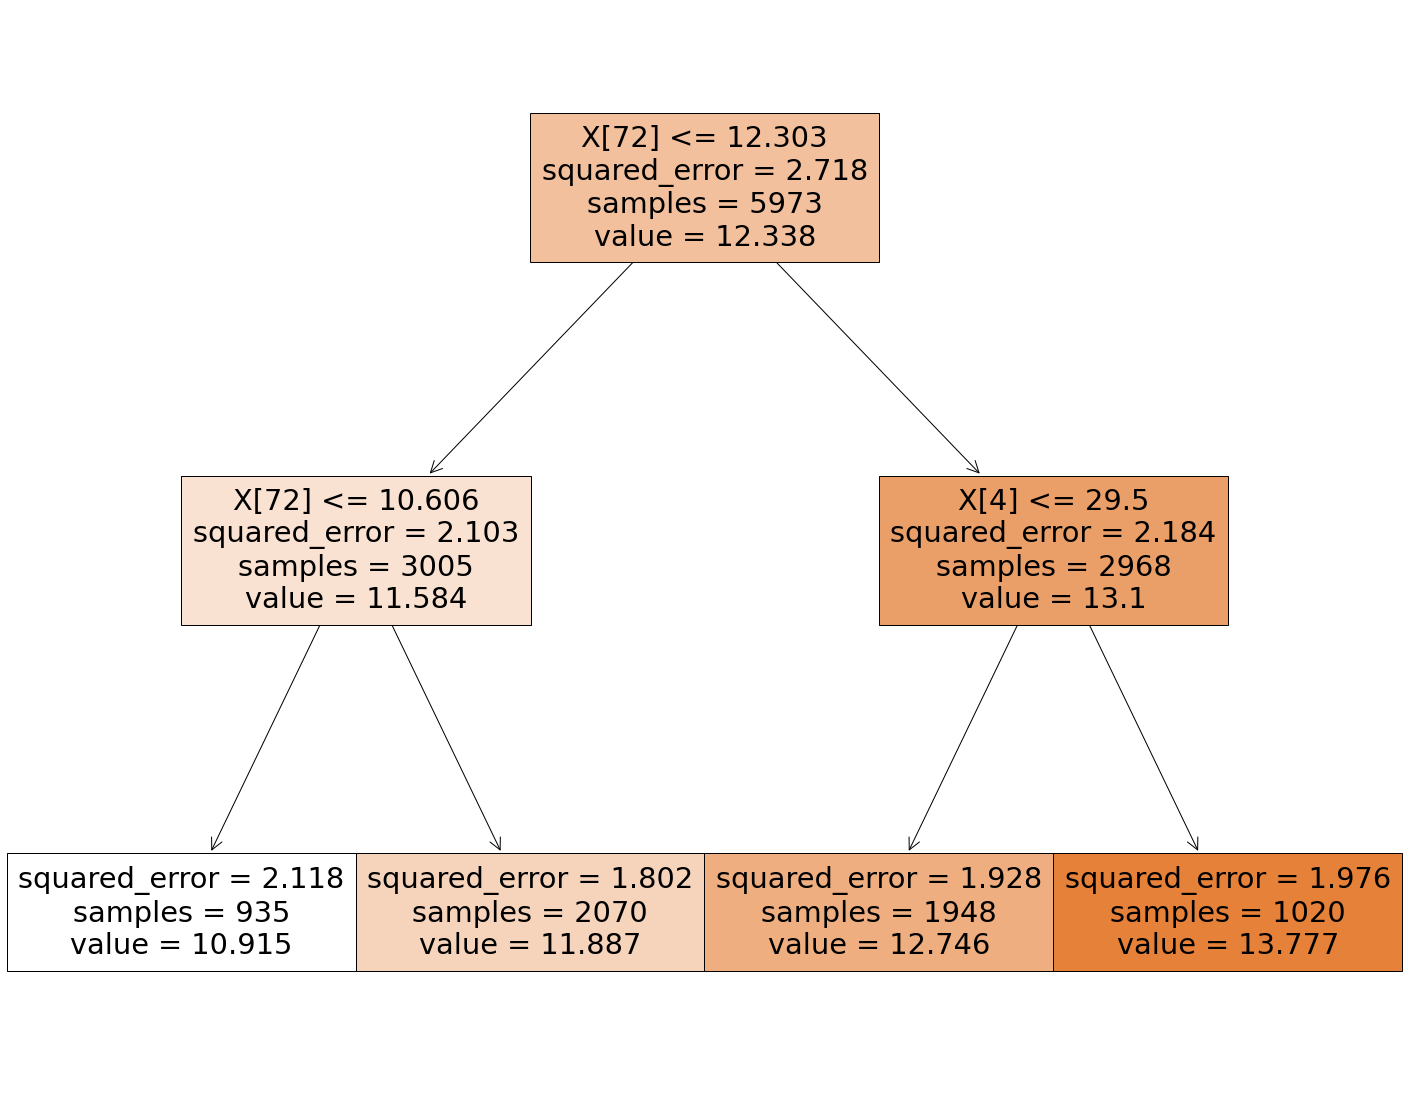

In [64]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr2,
                   filled=True)


# With adaboost

In [67]:
from sklearn.ensemble import AdaBoostRegressor

In [68]:
regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=5), n_estimators=300, random_state=np.random.RandomState(1)
)
regr_2.fit(trainX, trainy)
pred_2 = regr_2.predict(validX)
pred_2t = regr_2.predict(testX)
print("validation error: "+str(mean_squared_error(validy, pred_2)))
print("test error: "+str(mean_squared_error(testy, pred_2t)))

validation error: 1.845812127109504
test error: 2.1871749624446277
